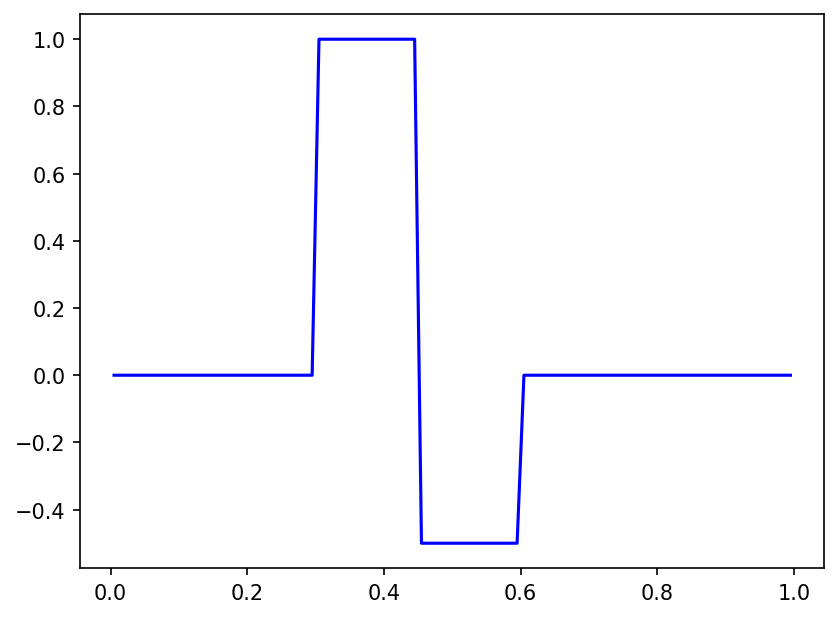

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from discretize import TensorMesh
from SimPEG import simulation, maps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 150

nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.cell_centers_x > 0.3] = 1.0
true_model[mesh.cell_centers_x > 0.45] = -0.5
true_model[mesh.cell_centers_x > 0.6] = 0

# Plotting the true model
plt.plot(mesh.cell_centers_x, true_model, "b-")

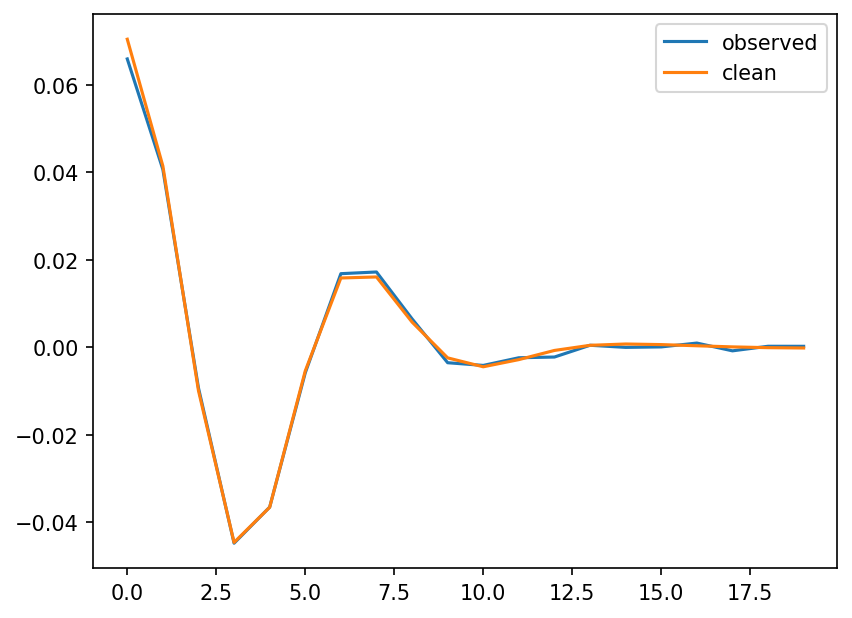

In [170]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial.
# The columns of the linear operator represents a set of decaying and oscillating functions.
sim = simulation.ExponentialSinusoidSimulation(
    model_map=maps.IdentityMap(), mesh=mesh, n_kernels=nData, p=-0.25, q=0.25, j0=1, jn=60
)
G = sim.G

# Standard deviation of Gaussian noise being added
data_std = 0.001
np.random.seed(3211)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, noise_floor=data_std, add_noise=True)

plt.plot(data_obj.dobs, label='observed')
plt.plot(data_obj.dclean, label='clean')
plt.legend()

(100, 100) (100,)


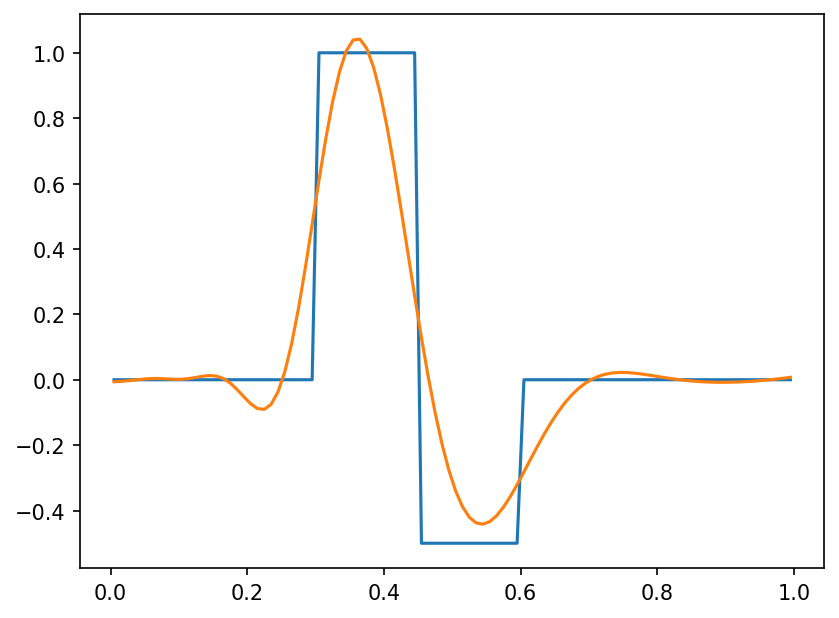

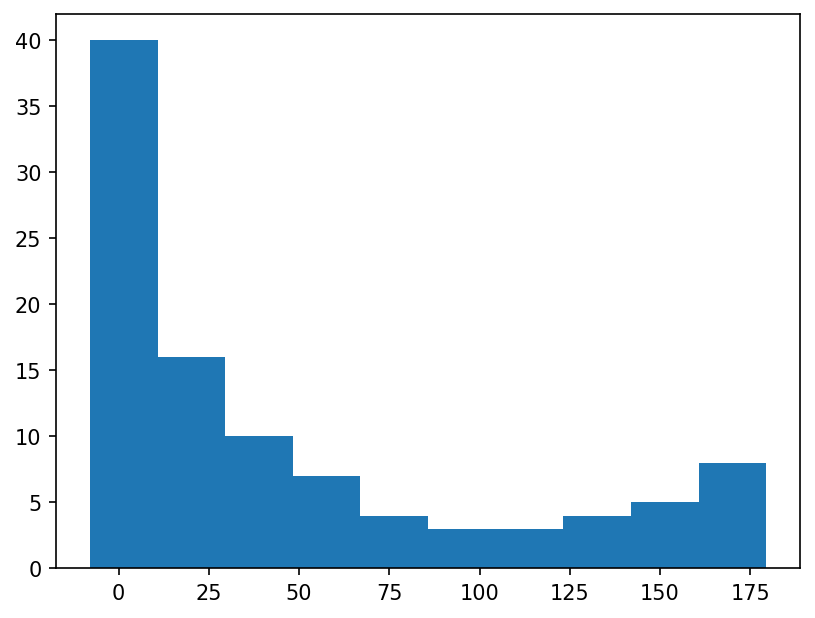

In [171]:
model_std = 0.4
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + 1/model_std**2 * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @  data_obj.dobs
print(A.shape, b.shape)
m_max_post = np.linalg.solve(A, b)

del_d = Wd @ (G @ m_max_post - data_obj.dobs)
# print(del_d.T @ del_d)

plt.plot(mesh.cell_centers_x, true_model)
plt.plot(mesh.cell_centers_x, m_max_post)

plt.show()

plt.hist((G.T @ Wd.T @ Wd @ data_obj.dobs).flatten())
plt.show()
# plt.hist((1/model_std**2 * np.eye(G.shape[1])).flatten())

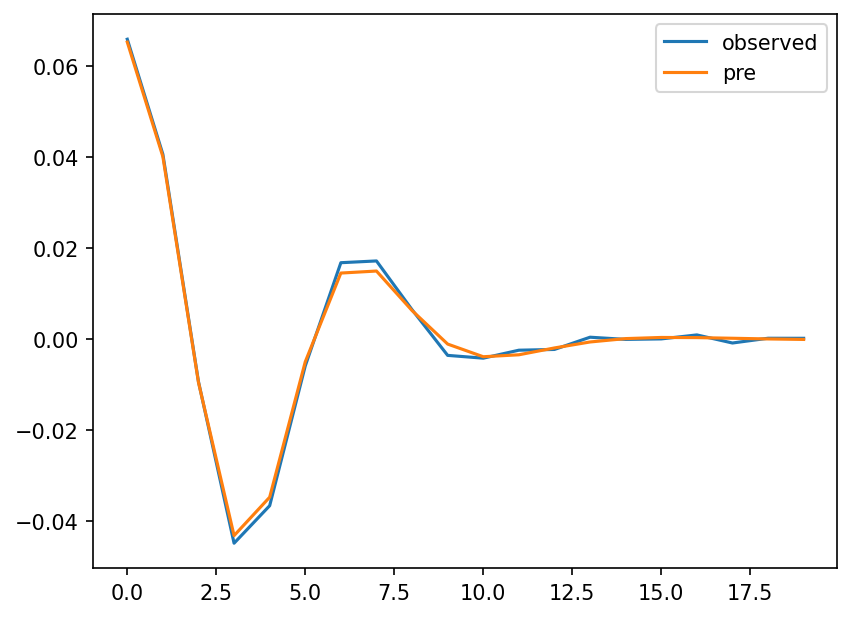

In [172]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(G @ m_max_post, label='pre')
plt.legend()

## Create the perturbed data distrubution

(20, 20) (1, 20)


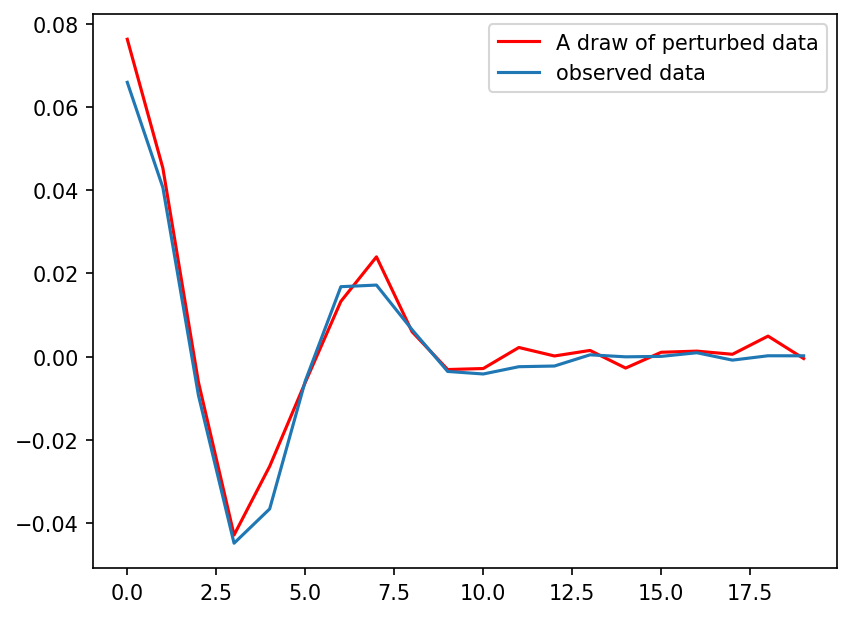

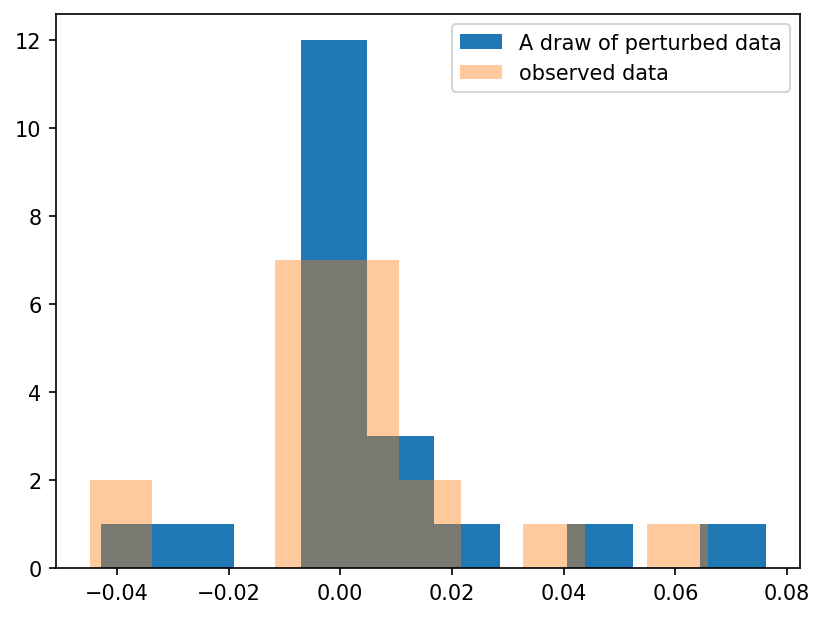

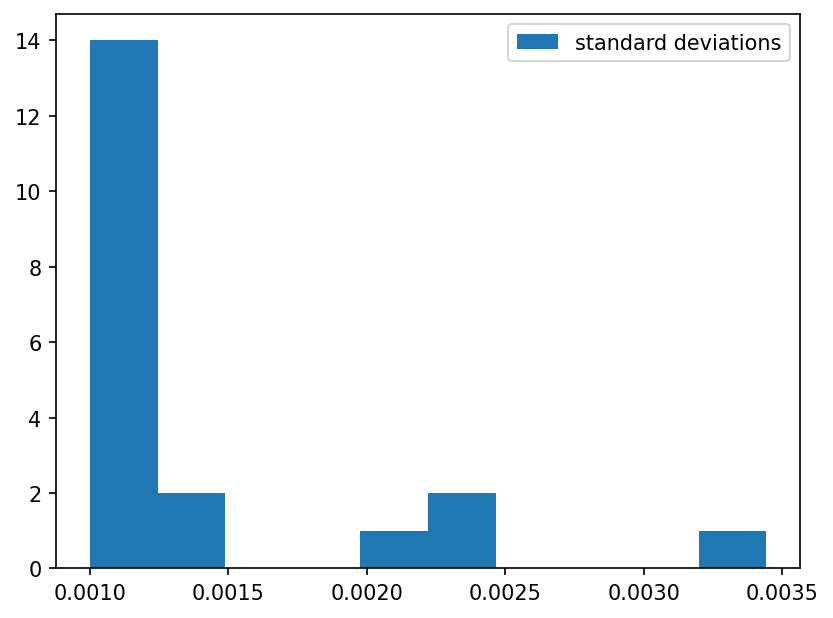

In [173]:
# Generate sample data
np.random.seed(0)

n_samples = 1000
n_components = 20
Wd = np.diag(data_obj.standard_deviation * 1e-2)

# Generate two Gaussian distribution
perturbed_data = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)

plt.plot(perturbed_data.T, 'r', label='A draw of perturbed data')
plt.plot(data_obj.dobs, label='observed data')
print(Wd.shape, perturbed_data.shape)
plt.legend()
plt.show()

plt.hist(perturbed_data.mean(axis=0), label='A draw of perturbed data')
plt.hist(data_obj.dobs, alpha=0.4, label='observed data')
plt.legend()
plt.show()

plt.hist(data_obj.standard_deviation, label='standard deviations')
plt.legend()
plt.show()

## create distrubution for perturbed model

(100, 100)
(1, 100) (100, 100)
(100, 1)


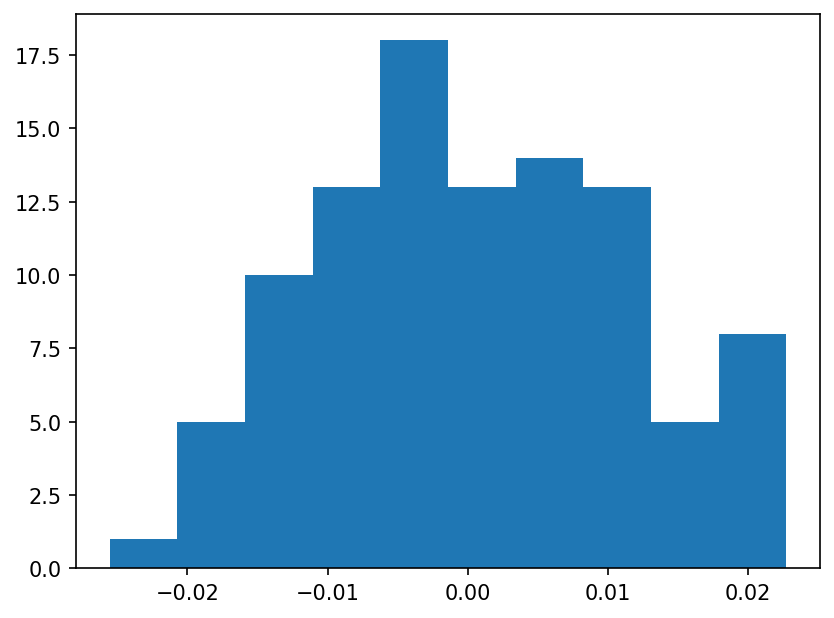

In [174]:
from scipy import linalg
mean = 0
mu = 1e4 #np.mean(data_obj.dobs)

identity_matrix = np.eye(100)
print(identity_matrix.shape)
zero_means = np.zeros(100)

s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

# coefficient matrix
Wm = np.sqrt(mu) * np.eye(100)
print(s.shape, Wm.shape)
perturbed_model = np.linalg.solve(Wm, s.T)
print(perturbed_model.shape)
plt.hist(perturbed_model)
plt.show()


(100, 100) (100, 1) (100, 1)


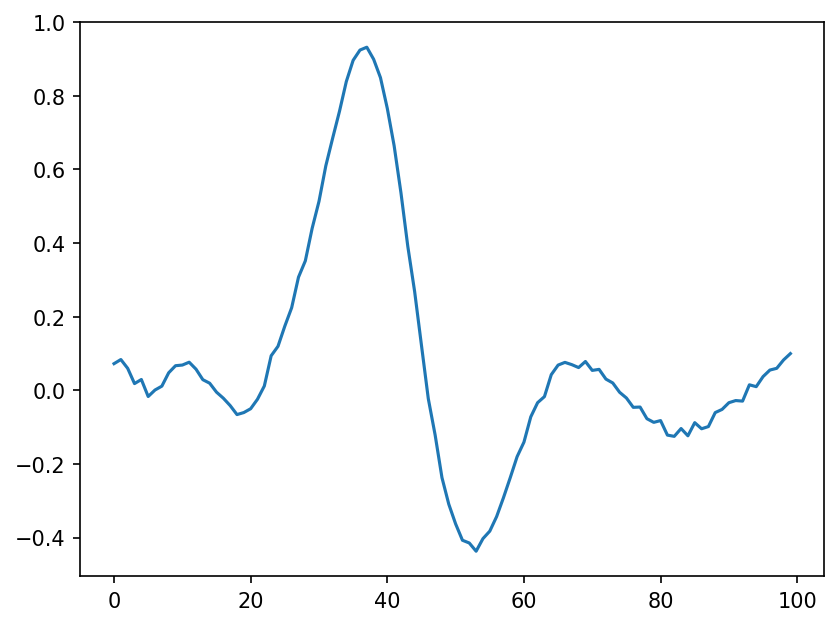

In [259]:
draws = []

Wm = linalg.inv(Wd)
mu = 1e1
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + mu * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu * np.eye(G.shape[1]) @ perturbed_model


m_max_post = np.linalg.solve(A, b)
draws = m_max_post
# draws = np.hstack(draws)
print(A.shape, b.shape, (G.T @ Wd.T @ Wd @ perturbed_data.T).shape )
plt.plot(draws)
# plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

# mu = 1e3
# A = G.T @ Wd.T @ Wd @ G
# b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu / 2


# m_max_post_l1 = np.linalg.solve(A, b)
# draws = m_max_post
# # draws = np.hstack(draws)
# print((G.T @ Wd.T @ Wd @ G).shape, (mu * np.eye(G.shape[1])).shape)
# # plt.plot(draws)
# # plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

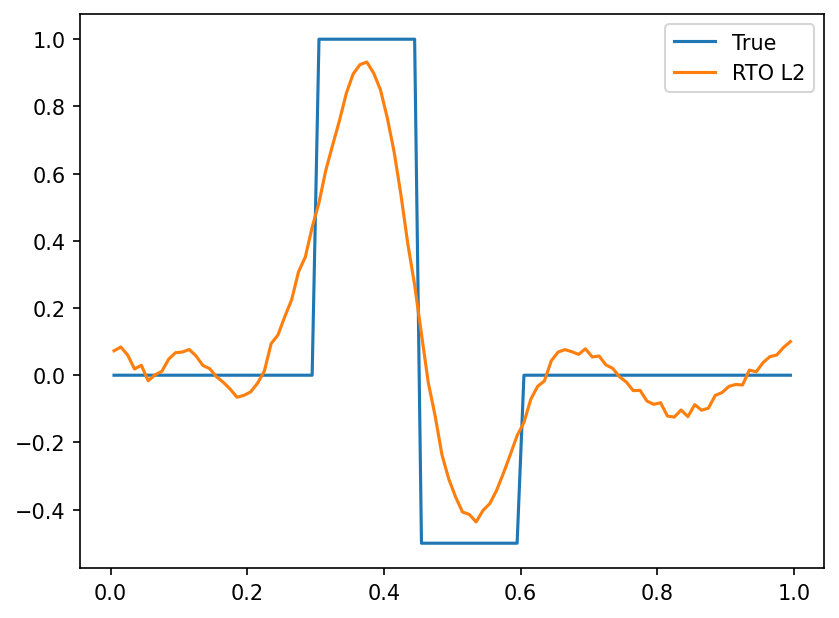

In [254]:
plt.plot(mesh.cell_centers_x, true_model, label='True')
plt.plot(mesh.cell_centers_x, draws, label='RTO L2')
# plt.plot(mesh.cell_centers_x, m_max_post_l1, label='RTOL1')
plt.legend()

## create function to perform rto

In [156]:
def randomize_them_optimize(
        
        dobs:np.ndarray,
        n_samples:int=50,
        n_model_samples:int=100,
        n_components:int=20,
        mu_init:float=1e1,
        mu_perturb:float=1e4,
        standard_deviation:np.ndarray=None,
        
    ) -> np.ndarray:

    # Generate sample data
    np.random.seed(0)

    # data covariace matrix to perturb data
    Wd = np.diag(standard_deviation)

    # model zero mean guassian distribution
    identity_matrix = np.eye(n_model_samples)
    zero_means = np.zeros(n_model_samples)

    draws = []

    for ii in range(n_samples):
    
        # draw from perturbed data distribution
        perturbed_data = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)

        # draw from perturbed model distribution
        s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

        # coefficient matrix
        Wm = np.sqrt(mu_perturb) * np.eye(n_model_samples)
        
        # solve linear equation for perturbed model
        perturbed_model = np.linalg.solve(Wm, s.T)

        # data covariance matrix
        Cd = np.diag(1 / standard_deviation)

        # solve foe model
        A = G.T @ Cd.T @ Cd @ G + mu_init * np.eye(G.shape[1])
        b = G.T @ Cd.T @ Cd @ perturbed_data.T + mu_init * np.eye(G.shape[1]) @ perturbed_model
        m_max_post = np.linalg.solve(A, b)
        draws.append(m_max_post)

    return np.hstack(draws)

    

In [157]:
results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=1000,
        n_model_samples=100,
        n_components=20,
        mu_init=1e1,
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        
)

(100, 1000)


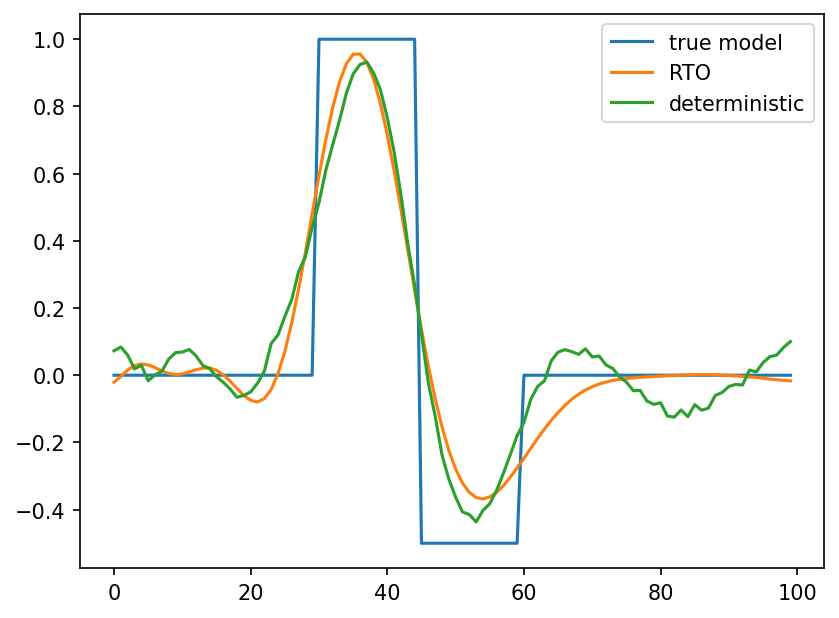

In [158]:
print(results.shape)
plt.plot(true_model, label='true model')
plt.plot(results.mean(axis=1), label='RTO')
plt.plot(m_max_post, label='deterministic')
plt.legend()

(100, 1000)


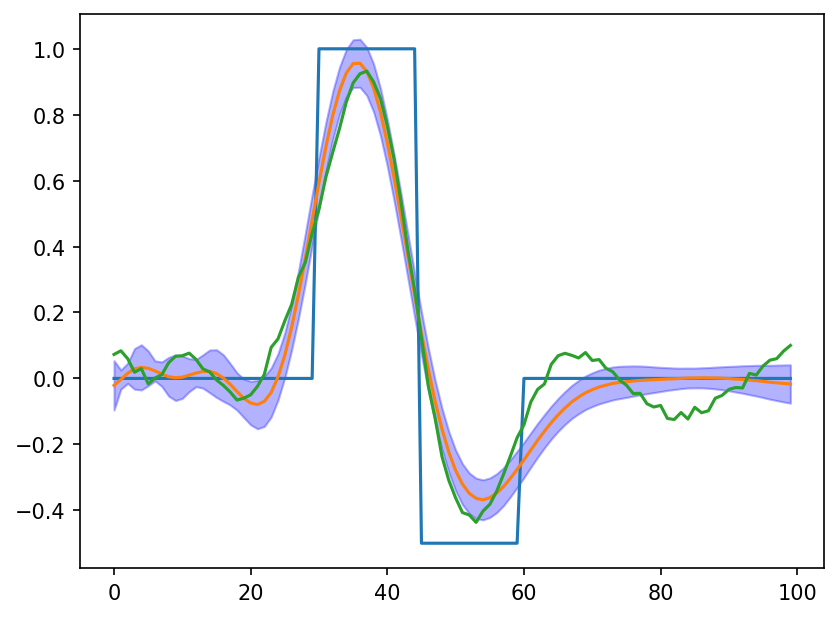

In [159]:
#some confidence interval
print(results.shape)
y = results.mean(axis=1)
ci = []
for ii in range(100):
    ci.append(1.96 * np.std(results[ii, :])/np.sqrt(results.shape[1]))

plt.fill_between(np.arange(100), (y-ci), (y+ci), color='b', alpha=.3)
plt.plot(true_model, label='true model')
plt.plot(results.mean(axis=1), label='RTO')
plt.plot(m_max_post, label='deterministic')


## TKO

In [166]:
1 / 0.00018

5555.555555555556

In [302]:
from scipy.sparse import spdiags
mu_ref = 1e1
mu_new = 1e3
mu_d = np.sqrt(mu_ref) / mu_ref
rto_model = results.mean(axis=1).T[:, None]
Wd = np.diag(data_obj.standard_deviation * 1e-2)
# perturbed data step 2
perturbed_data_2 = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)
print(mu_d, Wd.shape, G.shape, rto_model.shape, perturbed_data_2.shape, (rto_model @ rto_model.T).shape)
# # A =  G.T @ Wd.T @ Wd @ G @ spdiags(rto_model[:, 0], 0, 100, 100)
# A = G.T @ Wd.T @ Wd @ G @ rto_model
# b =  G.T @ Wd.T @ Wd @ perturbed_data_2.T
# print(A.shape, b.shape)
# m_max_post = mu_d * np.linalg.solve(A, b)

# plt.hist(m_max_post)
# print(m_max_post.mean())

# Example usage with the function f(x) = x^2 - 4x + 4
def objective_func(mu):
    r =  np.sqrt(mu_ref / mu) * Wd @ G @ rto_model  - Wd.T @ perturbed_data_2.T

    return 0.5 * np.linalg.norm(r)

def gradient_func(mu):
    A = G.T @ Wd.T @ Wd @ G @ rto_model
    B = G.T @ Wd.T @ Wd @ perturbed_data_2.T
    return np.sqrt(mu_ref / mu) * rto_model.T @ G.T @ Wd.T @ Wd @ G @ rto_model - rto_model.T @ G.T @ Wd.T @ perturbed_data_2.T

def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x):
    x = initial_x
    
    for i in range(iterations):
        # Calculate the gradient at the current point
        grad = gradient_func(x)
        
        # Update x using the gradient and learning rate
        x -= learning_rate * grad
        
        # Calculate the value of the objective function at the new point
        value = objective_func(x)
        
        # Print the current iteration and the value of the objective function
        print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
    
    return x

learning_rate = 0.1
iterations = 10
initial_x = 1

result = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
print("Final result: x =", result)
# print(gradient_func(initial_x))

0.31622776601683794 (20, 20) (20, 100) (100, 1) (1, 20) (100, 100)
Iteration 1: x = [[1.00000003]], f(x) = 2.80479945455487e-06
Iteration 2: x = [[1.00000006]], f(x) = 2.8047993916413863e-06
Iteration 3: x = [[1.00000009]], f(x) = 2.804799328727906e-06
Iteration 4: x = [[1.00000012]], f(x) = 2.80479926581443e-06
Iteration 5: x = [[1.00000014]], f(x) = 2.804799202900954e-06
Iteration 6: x = [[1.00000017]], f(x) = 2.804799139987483e-06
Iteration 7: x = [[1.0000002]], f(x) = 2.804799077074014e-06
Iteration 8: x = [[1.00000023]], f(x) = 2.8047990141605473e-06
Iteration 9: x = [[1.00000026]], f(x) = 2.8047989512470837e-06
Iteration 10: x = [[1.00000029]], f(x) = 2.8047988883336226e-06
Final result: x = [[1.00000029]]


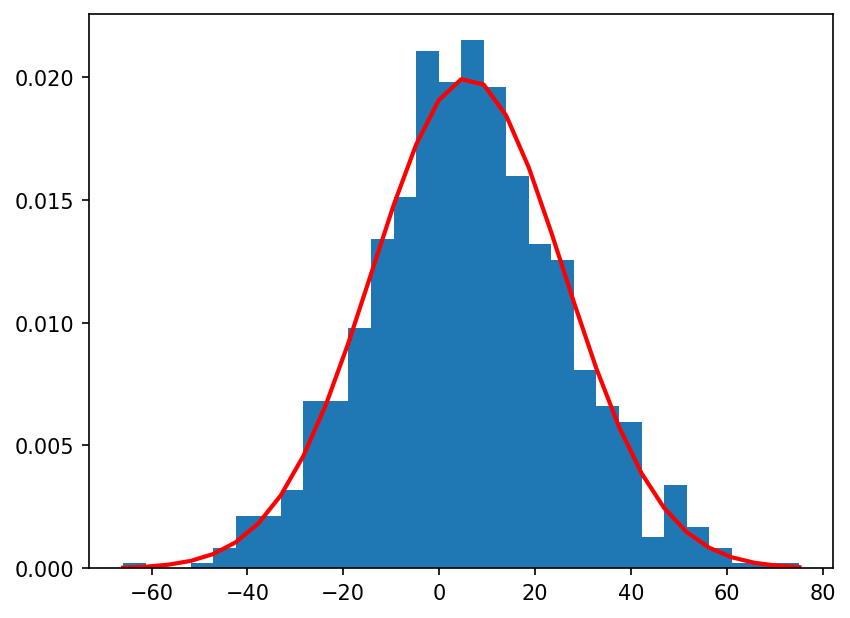

6


In [276]:
# plt.hist(m_max_post, label='deterministic')
# print(np.mode(m_max_post))
sigma = 20
p_mu = 6
s = np.random.normal(p_mu, sigma, 1000)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - p_mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

print(p_mu)

In [262]:
spdiags(rto_model[:, 0], 0, 100, 100).toarray()

array([[-0.02113162,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00349408,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01562298, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.01337209,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.01521247,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.01691418]])